In [1]:
# If you have ROS in your system please uncomment the two lines below
# import sys
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import numpy as np
from pathlib import Path

from hfnet.settings import EXPER_PATH
from notebooks.utils import plot_images, plot_matches, add_frame

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/server/anaconda3/envs/hfnet/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/server/anaconda3/envs/hfnet/lib/python3.6/s

# Load query (night) and database (day) images

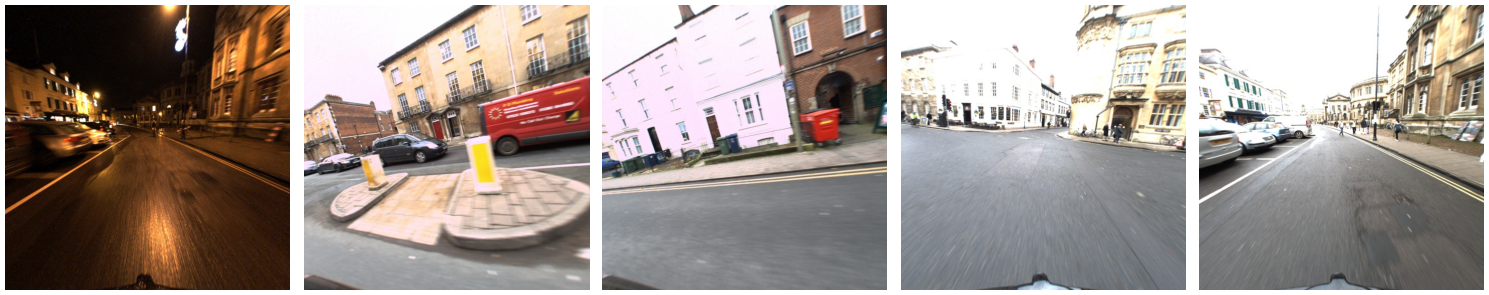

In [2]:
query_idx = 1  # also try with 2 and 3
read_image = lambda n: cv2.imread('doc/demo/demo_images/' + n)[:, :, ::-1]
image_query = read_image(f'query{query_idx}.jpg')
images_db = [read_image(f'db{i}.jpg') for i in range(1, 5)]

plot_images([image_query] + images_db, dpi=50)

# Create HF-Net model for inference

In [3]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')
        self.scores_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')
        
    def inference(self, image, nms_radius=4, num_keypoints=1000, scores=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
            self.scores_op: scores
        }
        return self.session.run(self.outputs, feed_dict=inputs)

model_path = Path(EXPER_PATH, 'hfnet_vanilla')
# model_path = Path(EXPER_PATH, 'hfnet_vanilla')
outputs = ['global_descriptor', 'keypoints', 'local_descriptors', 'scores']
hfnet = HFNet(model_path, outputs)

[01/20/2023 12:45:35 INFO] Restoring parameters from /media/server/145230403A575068/phd/phdExperiments/hfnetData/log/hfnet_vanilla/variables/variables


In [6]:
img = cv2.imread('/home/server/hfnet/hfnet/doc/demo/demo_images/db1.jpg')
print(hfnet.inference(img))

{'global_descriptor': array([ 0.0407298 , -0.02652736, -0.01816067, ...,  0.014334  ,
       -0.01435031, -0.01201794], dtype=float32), 'keypoints': array([[665, 265],
       [540, 283],
       [440, 507],
       ...,
       [576, 630],
       [898, 132],
       [785, 592]], dtype=int32), 'local_descriptors': array([[ 3.8867284e-02,  9.6985344e-03, -3.9435308e-03, ...,
         3.3055715e-02,  4.7276713e-02, -2.9605787e-02],
       [-1.6677668e-02,  1.8968204e-02, -1.3828686e-01, ...,
        -1.0290058e-01, -8.8309133e-03,  6.0445484e-02],
       [ 4.8173960e-02,  3.8128488e-02,  2.5926717e-02, ...,
        -2.2358691e-02,  7.2391964e-02,  2.5155565e-02],
       ...,
       [-2.8452914e-02, -5.7748631e-02, -1.3220213e-02, ...,
         2.3185281e-02, -1.1019862e-01,  5.4754719e-02],
       [ 5.6574992e-03, -7.7178650e-02,  8.7795749e-02, ...,
        -1.1019804e-02,  1.9369552e-02,  1.3682827e-01],
       [ 6.8670347e-02, -1.0672100e-04, -5.2415691e-02, ...,
        -4.5799915e-02,  4

# Compute global descriptors and local features for query and database

In [4]:
db = [hfnet.inference(i) for i in images_db]
global_index = np.stack([d['global_descriptor'] for d in db])
query = hfnet.inference(image_query)

# Perform a global search in the database

In [5]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

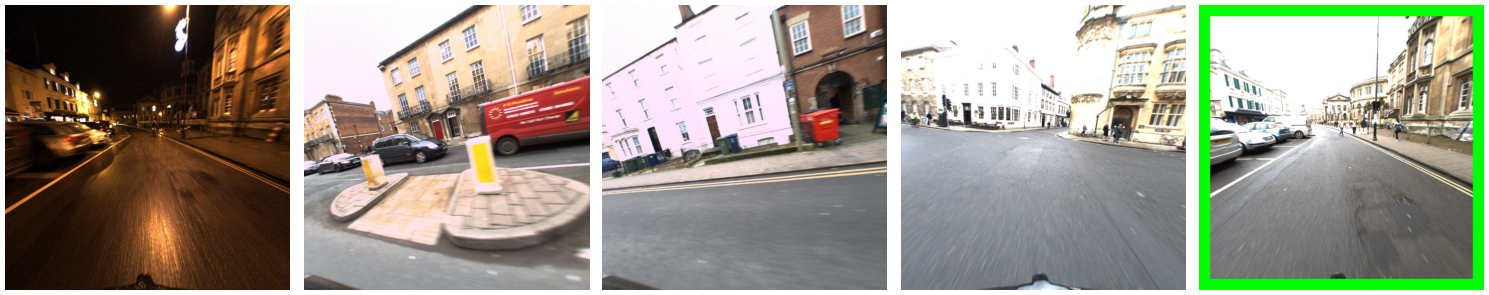

In [6]:
nearest = np.argmin(compute_distance(query['global_descriptor'], global_index))

disp_db = [add_frame(im, (0, 255, 0)) if i == nearest else im
           for i, im in enumerate(images_db)]
plot_images([image_query] + disp_db, dpi=50)

# Perform local matching with the retrieved image

In [7]:
def match_with_ratio_test(desc1, desc2, thresh):
    dist = compute_distance(desc1, desc2)
    nearest = np.argpartition(dist, 2, axis=-1)[:, :2]
    dist_nearest = np.take_along_axis(dist, nearest, axis=-1)
    valid_mask = dist_nearest[:, 0] <= (thresh**2)*dist_nearest[:, 1]
    matches = np.stack([np.where(valid_mask)[0], nearest[valid_mask][:, 0]], 1)
    return matches

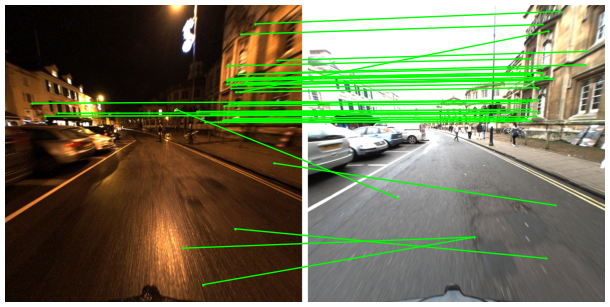

In [8]:
matches = match_with_ratio_test(query['local_descriptors'],
                                db[nearest]['local_descriptors'], 0.8)

plot_matches(image_query, query['keypoints'],
             images_db[nearest], db[nearest]['keypoints'],
             matches, color=(0, 1, 0), dpi=50)